# DATATHON25 Neurotech Track

## DEFINITIONS
### COH: Coherence (i.e. phase coherence of two signals; delay in activation and response).
### AB: Power Spectrum Density (i.e. power distribution in frequency-space).
### F (frontal), P (parietal), O (occipital), T (temporal), Fp (frontopolar), C (central): Designates the lobe of the brain on which the electrode was placed. An odd number next to the letter represents the left side of the head while an even number represents the right side
### Fz, Cz, Pz: Designates the electrode is placed along the midline of the head.
### A (delta), B (theta), C (alpha), D (beta), E (high beta), F (gamma): Designates the frequency range of the wave measured. A = [0.5, 4) Hz, B = [4-8) Hz, C = [8-12) Hz, D = [12-25) Hz, E = [25-30) Hz, F = [30-40) Hz

## COLUMN NAMING CONVENTION
#### AB or COH
#### A, B, C, D, E, F
#### Frequency band name
#### Lowercase letter representing a single electrode starting from left-front to right-back of the head (e.g. a = Fp1, b = Fp2, c = F7, ..., r = O1, s = O2)
#### F, P, O, T, Fp, C, Fz, Cz, Pz (with corresponding odd or even number designation)
#### IF COH, another lowercase letter representing the second electrode
#### IF COH, another electrode designation with corresponding odd or even number

## COLUMN NAMING EXAMPLES
#### AB.A.delta.a.Fp1 = PSD value in the delta band measured by the electrode placed on the frontopolar lobe.
#### AB.B.theta.g.F8 = PSD value in the theta band by the electrode placed on the outermost part of the right frontal lobe.
#### COH.A.delta.a.Fp1.b.Fp2 = Coherence value in the delta band between the electrodes placed on the left and right frontopolar lobes.
## ===========================================================================================================================

In [10]:
# Install required libraries if not already installed
#!pip install numpy
#!pip install pandas
#!pip install scipy
#!pip install scikit-learn
#!pip install feature_engine

# Initialize required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import string
#from scipy.stats import entropy, differential_entropy
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.feature_selection import RFECV, mutual_info_classif, mutual_info_regression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV

### Define auxiliary functions used to process the data

In [11]:
def letter2band(letter):
    """
    Converts from a 'letter' designation to the name of the frequency band
    corresponding to that letter
    INPUTS:
            - letter:    char object corresponding to the letter designation of a specific frequency band
            
    OUTPUTS:
            - band_name: string name of the frequency band corresponding to the input letter designation
    """
    conversion_dict = {'A': 'delta', 'B': 'theta', 'C': 'alpha', 'D': 'beta', 'E': 'highbeta', 'F': 'gamma'}

    return conversion_dict[letter]

def letter2lobe(letter):
    """
    Converts from a 'letter' designation to the name of the lobe of the brain where the
    electrode is placed
    INPUTS:
            - letter:    char object corresponding to the letter designation of a specific lobe
            
    OUTPUTS:
            - band_name: string name of the lobe corresponding to the input letter designation
    """
    conversion_dict = {'a': 'Fp1', 'b': 'Fp2', 'c': 'F7', 'd':'F3', 'e': 'Fz', 'f': 'F4', 
                       'g': 'F8', 'h': 'T3', 'i': 'C3', 'j': 'Cz', 'k': 'C4', 'l': 'T4', 
                       'm': 'T5', 'n': 'P3', 'o':'Pz', 'p': 'P4', 'q': 'T6', 'r': 'O1', 's': 'O2'}

    return conversion_dict[letter]

def plot_feature_distributions(col_names):
    """
    Plots the distribution of the maximally-informative columns in the data according to type of
    signal (i.e. PSD or Coherence), frequency band, and lobe.
    INPUTS:
            - col_names: list of strings corresponding to the feature names

    OUTPUTS:
            - NONE
    """
    # Define the column-name substrings that correspond to different EEG parameters in dictionaries
    # whose key-value pairs correspond to parameter-count pairs
    signal_features = {'AB': 0, 'COH': 0}
    bands = {'A': 0, 'B': 0, 'C': 0, 'D': 0, 'E': 0, 'F': 0}
    lobes = {letter: 0 for letter in list(string.ascii_lowercase)[:19]}
    
    # Populate the dictionaries by counting how many times each key appears in any of the column names
    for feature in col_names:
        # Split the string to determine the presence of each parameters
        feature = feature.split('.')
        if len(feature) > 1:
            if 'AB' in feature:
                signal_features['AB'] += 1
                bands[list(set(bands.keys()) & set(feature))[0]] += 1
                lobes[list(set(lobes.keys()) & set(feature))[0]] += 1 
            else:
                signal_features['COH'] += 1
                bands[list(set(bands.keys()) & set(feature))[0]] += 1
                lobes_present = list(set(lobes.keys()) & set(feature))
                lobes[lobes_present[0]] += 1
                lobes[lobes_present[1]] += 1

    # Plot the distribution of signal types
    plt.figure(figsize = (3, 3))
    plt.bar(signal_features.keys(), signal_features.values())
    plt.show()
    # Plot the distribution of frequency bands
    plt.figure(figsize = (5.5, 3))
    plt.bar([letter2band(key) for key in bands.keys()], bands.values())
    plt.show()
    # Plot the distribution of lobes
    plt.figure(figsize = (7.5, 3))
    plt.bar([letter2lobe(key) for key in lobes.keys()], lobes.values())
    plt.show()

### Define the feature selection algorithm

In [12]:
def featureSelectionJMIM(feats, target, k):
    """ 
    Use the Joint Mutual Information Maximisation (JMIM) algorithm 
    developed by M. Bennasar, Y. Hicks, and R. Setchi (2015) to extract
    a subset of maximally-informative features from the full data
    INPUTS:
            - feats:      Pandas DataFrame whose columns are the features of 
                          the data. Must NOT contain missing or NaN values.
            - target:     Pandas DataFrame whose values are class labels of each
                          observation in the dataset.
            - k:          Desired size of the subset of maximally-informative 
                          features.
    OUTPUTS:
            - features_k: Pandas DataFrame with k columns from the features
                          DataFrame that maximize the mutual information
                          with the target DataFrame
    """
    # Initialize dataframe to store the maximally-informative features subset
    features = feats.copy()
    features_k = pd.DataFrame(index = features.index)
    
    # For selecting the first feature, initialize a variable to store the largest mutual information (MI)
    # value and a variable to record the column name of the feature that achieves this largest JMI value.
    # Iterate through the features and find the MI between each feature and the target. Then, transfer the
    # feature with the largest MI with the target to the features_k dataframe
    max_mi = 0
    max_mi_feature = ''
    for col in features.columns:
        mi = mutual_info(features[[col]], target)
        if mi > max_mi:
            max_mi = mi
            max_mi_feature = col
    features_k = features_k.join(features[[max_mi_feature]])
    features.drop(columns = max_mi_feature, axis = 1, inplace = True)
    #print(features.head())
    
    # For each remaining features, apply the following algorith: 
    #    1) Select one of the remaining features
    #    2) Compute the JMI between the joint pair of the new feature and each of the already-selected 
    #       features with the target (i.e. I(X,Y;C))
    #    3) Determine the minimum value of the JMI and store this value along with the new feature's name
    #    4) Iterate steps 1-3 for each of the remaining features
    #    5) Determine the feature for which the value of the JMI in step 3 is maximized. This feature will
    #       be added to the features_k dataframe
    #    6) Repeat steps 1-5 until the features_k dataframe has k columns
    for i in range(1, k):
        min_jmi_dict = {}
        for col_new in features.columns:
            min_jmi = -np.inf
            for col_selected in features_k:
                jmi = joint_mutual_info(features[[col_new]], features_k[[col_selected]], target)
                if jmi > min_jmi:
                    min_jmi = jmi
            min_jmi_dict[col_new] = min_jmi
        max_jmi_feature = max(min_jmi_dict, key = min_jmi_dict.get)            
        features_k = features_k.join(features[[max_jmi_feature]])
        features.drop(columns = max_jmi_feature, axis = 1, inplace = True)
        #print(features_k.head())

    # Output the features_k dataframe
    return features_k

## Information Theory:
* ### Mutual Information: I(X;Y) = H(X) + H(X|Y) = I(Y;X)
* ### Joint Mutual Information: I(X,Y;C) = I(X;C) + I(Y;C) - I(X;Y) + I(X;Y|C)

In [13]:
def mutual_info(X,Y):
    """
    Compute the mutual information between the input variables X and Y
    INPUTS:
            - X:    Pandas DataFrame object corresponding to either a continuous or discrete random variable
            - Y:    Pandas DataFrame object corresponding to either a continuous or discrete random variable

    OUTPUTS:
            - I_xy: scalar value of the mutual entropy between variables X and Y
    """
    # Determine if the input variables are discrete but numerical, discrete but categorical, or continuous
    X_discrete = len(X.value_counts()) < 10
    X_categorical = X.dtypes.iloc[0] == 'object'
    Y_discrete = len(Y.value_counts()) < 10
    Y_categorical = Y.dtypes.iloc[0] == 'object'
    
    # If both variables are discrete, use the Shannon entropy to determine the mutual information. Additionally,
    # if at least one of the variables is categorical, encode categorical values as integers for classification.
    # If one variable is continuous and the other is discrete but not categorical, use the differential entropy 
    # to determine the mutual information
    if X_discrete & Y_discrete:
        if X_categorical & Y_categorical:
            A = OrdinalEncoder().fit_transform(X)
            B = OrdinalEncoder().fit_transform(Y)
        elif X_categorical:
            A = Y.to_numpy()
            B = OrdinalEncoder().fit_transform(X)
        elif Y_categorical:
            A = X.to_numpy()
            B = OrdinalEncoder().fit_transform(Y)
        else:
            A = X.to_numpy()
            B = Y.to_numpy()
        I_xy = mutual_info_classif(A, B.flatten(), discrete_features = True)
    else:
        if X_discrete:
            if X_categorical:
                A = Y.to_numpy()
                B = OrdinalEncoder().fit_transform(X)
                I_xy = mutual_info_classif(A, B.flatten(), discrete_features = False)
            else:
                A = X.to_numpy()
                B = Y.to_numpy()
                I_xy = mutual_info_regression(A, B.flatten(), discrete_features = True)
        elif Y_discrete:
            if Y_categorical:
                A = X.to_numpy()
                B = OrdinalEncoder().fit_transform(Y)
                I_xy = mutual_info_classif(A, B.flatten(), discrete_features = False)
            else:
                A = Y.to_numpy()
                B = X.to_numpy()
                I_xy = mutual_info_regression(A, B.flatten(), discrete_features = True)
        else:
            I_xy = mutual_info_regression(X.to_numpy(), Y.to_numpy().flatten(), discrete_features = False)
        
    return I_xy[0]

def joint_mutual_info(X, Y, C):
    """
    Compute the mutual information between the joint input X and Y and the target variable C
    INPUTS:
            - X:    Pandas DataFrame object corresponding to either a continuous or discrete random variable
            - Y:    Pandas DataFrame object corresponding to either a continuous or discrete random variable
            - C:    Pandas DataFrame object corresponding to a categorical (discrete) random variable

    OUTPUTS:
            - I_xy_c: scalar value of the joint mutual information between the joint input variables X and Y
                      and the target variable C
    """
    # Determine if the input variables are discrete or continuous
    X_discrete = len(X.value_counts()) < 10
    X_categorical = X.dtypes.iloc[0] == 'object'
    Y_discrete = len(Y.value_counts()) < 10
    Y_categorical = Y.dtypes.iloc[0] == 'object'

    # Determine the unique categories in the target variable. The data will then be grouped according to these
    # unique entries when computing the joint mutual entropy.
    C_unique_vals = C[C.columns[0]].unique()
    C_probs = C.value_counts().to_numpy()/len(C)
    
    # If both variables are discrete, use the Shannon entropy to determine the mutual information. Additionally,
    # if at least one of the variables is categorical, encode categorical values as integers for classification.
    # If one variable is continuous and the other is discrete but not categorical, use the differential entropy 
    # to determine the mutual information
    I_xy_c = mutual_info(Y,C) + mutual_info(X,C) - mutual_info(X,Y)
    for idx, c_val in enumerate(C_unique_vals):
        prob_c = C_probs[idx]
        X_given_c = X[C[C.columns[0]] == c_val]
        Y_given_c = Y[C[C.columns[0]] == c_val]
        if X_discrete & Y_discrete:
            if X_categorical & Y_categorical:
                A = OrdinalEncoder().fit_transform(X_given_c)
                B = OrdinalEncoder().fit_transform(Y_given_c)
            elif X_categorical:
                A = Y_given_c.to_numpy()
                B = OrdinalEncoder().fit_transform(X_given_c)
            elif Y_categorical:
                A = X_given_c.to_numpy()
                B = OrdinalEncoder().fit_transform(Y_given_c)
            else:
                A = X_given_c.to_numpy()
                B = Y_given_c.to_numpy()
            I_xy_c += prob_c * mutual_info_classif(A, B.flatten(), discrete_features = True)[0]
        else:
            if X_discrete:
                if X_categorical:
                    A = Y_given_c.to_numpy()
                    B = OrdinalEncoder().fit_transform(X_given_c)
                    I_xy_c += prob_c * mutual_info_classif(A, B.flatten(), discrete_features = False)[0]
                else:
                    A = X_given_c.to_numpy()
                    B = Y_given_c.to_numpy()
                    I_xy_c += prob_c * mutual_info_regression(A, B.flatten(), discrete_features = True)[0]
            elif Y_discrete:
                if Y_categorical:
                    A = X_given_c.to_numpy()
                    B = OrdinalEncoder().fit_transform(Y_given_c).to_numpy()
                    I_xy_c += prob_c * mutual_info_classif(A, B.flatten(), discrete_features = False)[0]
                else:
                    A = Y_given_c.to_numpy()
                    B = X_given_c.to_numpy()
                    I_xy_c += prob_c * mutual_info_regression(A, B.flatten(), discrete_features = True)[0]
            else:
                I_xy_c += prob_c * mutual_info_regression(X_given_c.to_numpy(), Y_given_c.to_numpy().flatten(),
                                                          discrete_features = False)[0]
        
    return I_xy_c

### Define a function to model a single disorder against the healthy control samples

In [29]:
def fit_disorder(x_train, y_train, disorder_label, num_features, plotRFE = False, plotJMIM = False):
    # Create a subset of the x_train and y_train data that includes only the rows for which the value in the
    # y_train columns is either 'Addictive disorder' or 'Healthy control'
    bool_rows = [val == disorder_label or val == 'Healthy control' for val in y_train.to_list()]
    x_train_dis = x_train.loc[bool_rows, :]
    y_train_dis = y_train.loc[bool_rows]

    # Use a recursive feature elimination algorithm to compare to the results of the JMIM algorithm
    x_train_dis_normed = StandardScaler().fit_transform(x_train_dis)
    y_train_dis_enc = LabelEncoder().fit_transform(y_train_dis)
    feature_optimizer_dis = RFECV(estimator = RidgeClassifier(),
                              step = 10,
                              cv = StratifiedKFold(10),
                              scoring= 'accuracy',
                              min_features_to_select = 1,
                              n_jobs=4).fit(x_train_dis_normed, y_train_dis_enc)
    print('Optimal number of features: {}'.format(feature_optimizer_dis.n_features_))
    optimizer_results = pd.DataFrame(feature_optimizer_dis.cv_results_)
    if plotRFE:
        plt.figure()
        plt.xlabel('Number of features selected')
        plt.ylabel('Mean test accuracy')
        plt.plot(optimizer_results['n_features'], optimizer_results['mean_test_score'])
        plt.title("Recursive Feature Elimination \nwith correlated features")
        plt.show()

    # Apply the JMIM algorithm to find the subset of maximally-informative features with size given
    # by num_features. Then store the labels of each feature.
    x_train_dis_k = featureSelectionJMIM(x_train_dis, y_train_dis.to_frame(), num_features)
    col_names_dis = x_train_dis_k.columns
    
    # Initialize dictionaries to store the accuracy of the models with different classifier
    accuracy_scores_dis_knn = {num_features: []}
    accuracy_scores_dis_logistic = {num_features: []}
    accuracy_scores_dis_ridge = {num_features: []}

    # Train and evaluate several OneVsRest models with different estimators to determine the best estimator
    for k in range(1,num_features+1):
        x_train_dis_k_normed = StandardScaler().fit_transform(x_train_dis_k.iloc[:,range(k)])
        accuracy_scores_dis_knn[k] = np.mean(cross_val_score(OneVsRestClassifier(KNeighborsClassifier(n_neighbors = 10)),
                                                            x_train_dis_k_normed, y_train_dis_enc, cv = 10))
        accuracy_scores_dis_logistic[k] = np.mean(cross_val_score(OneVsRestClassifier(LogisticRegression()),
                                                                 x_train_dis_k_normed, y_train_dis_enc, cv = 10))
        accuracy_scores_dis_ridge[k] = np.mean(cross_val_score(OneVsRestClassifier(RidgeClassifier()),
                                                              x_train_dis_k_normed, y_train_dis_enc, cv = 10))
    print('Largest mean accuracy for OneVsRest Classifier with K-Nearest Neighbors estimator: {}'.format(
        max(list(accuracy_scores_dis_knn.values()))))
    print('Largest mean accuracy for OneVsRest Classifier with Logistic Regression estimator: {}'.format(
        max(list(accuracy_scores_dis_logistic.values()))))
    print('Largest mean accuracy for OneVsRest Classifier with Ridge Classifier estimator: {}'.format(
        max(list(accuracy_scores_dis_ridge.values()))))
    if plotJMIM:
        fig = plt.figure(figsize = (9, 4))
        grid = fig.add_gridspec(nrows = 1, ncols = 3, wspace = 2)
        axs = grid.subplots()
        fig.suptitle = 'Feature Selection Using \nJoint Mutual Information Maximization'
        axs[0].plot(accuracy_scores_dis_knn.keys(), list(accuracy_scores_dis_knn.values()))
        axs[0].set_title('OneVsAll w/ KNN Classifer')
        axs[0].set_box_aspect(2.5)
        axs[1].plot(accuracy_scores_dis_logistic.keys(), list(accuracy_scores_dis_logistic.values()))
        axs[1].set_title('OneVsAll w/ Logistic Regressor Classifer')
        axs[1].set_box_aspect(2.5)
        axs[2].plot(accuracy_scores_dis_ridge.keys(), list(accuracy_scores_dis_ridge.values()))
        axs[2].set_title('OneVsAll w/ Ridge Classifer')
        axs[2].set_box_aspect(2.5)
        for ax in axs.flat:
            ax.set(xlabel = 'Number of features selected', ylabel = 'Mean test accuracy')
        plt.show()

    # Determine the optimal number of features
    model_dicts = {'K-Nearest Neighbors': accuracy_scores_dis_knn,
                   'Logistic': accuracy_scores_dis_logistic,
                   'Ridge': accuracy_scores_dis_ridge}
    n_features_optim = 0
    for model_name, model_scores in model_dicts.items():
        n_model_optim = max(model_scores, key = model_scores.get)
        if n_model_optim > n_features_optim:
            n_features_optim = n_model_optim
            best_model = model_name
    x_train_dis_optim = x_train_dis_k.iloc[:,range(n_features_optim)]
    print('Best performing estimator is '+model_name+' with {} features'.format(n_features_optim))
    
    return x_train_dis_optim, y_train_dis_enc, n_features_optim

### Load the training data for the model

In [15]:
# Import training data into a dataframe and display the first 5 rows
train_set_filename = 'Train_and_Validate_EEG.csv'
train_set = pd.read_csv(train_set_filename, header = 0)
train_set.head()

,ID,sex,age,eeg.date,education,IQ,main.disorder,specific.disorder,AB.A.delta.a.FP1,AB.A.delta.b.FP2,...,COH.F.gamma.o.Pz.p.P4,COH.F.gamma.o.Pz.q.T6,COH.F.gamma.o.Pz.r.O1,COH.F.gamma.o.Pz.s.O2,COH.F.gamma.p.P4.q.T6,COH.F.gamma.p.P4.r.O1,COH.F.gamma.p.P4.s.O2,COH.F.gamma.q.T6.r.O1,COH.F.gamma.q.T6.s.O2,COH.F.gamma.r.O1.s.O2
0,1,F,31.55,2016.4.7,16.0,103.0,Mood disorder,Depressive disorder,48.843890,46.533704,...,84.825697,62.094883,49.639937,61.347225,81.630630,39.464753,72.168580,30.893891,74.038603,51.237679
1,2,M,25.00,2018.3.23,16.0,115.0,Healthy control,Healthy control,34.108015,22.838567,...,77.398455,48.282117,73.185133,66.742485,49.466312,59.270167,66.639938,40.297206,55.547526,63.630547
2,3,M,26.20,2015.4.10,16.0,83.0,Schizophrenia,Schizophrenia,31.084064,28.212342,...,91.510025,51.974239,62.571143,75.509166,56.460421,64.001966,78.424703,53.494830,66.581021,80.202968
3,4,M,21.00,2016.5.13,15.0,NaN,Obsessive compulsive disorder,Obsessive compulsitve disorder,14.310468,13.947459,...,79.855172,42.420095,56.473788,54.241183,69.561898,41.384408,66.332780,30.034691,65.659003,54.662177
4,5,F,28.15,2018.7.14,18.0,101.0,Healthy control,Healthy control,21.763093,23.938428,...,38.160508,21.319727,32.967416,33.401386,37.406879,27.080760,39.050046,14.826695,32.285940,41.015604


In [16]:
# Get a summary of the data types of the columns of the dataset
train_set.dtypes.value_counts()

float64    1144
object        4
int64         1
Name: count, dtype: int64

### Based on the first five rows and the summary of data types, it seems that the column data types of the PSD and COH values are all floats, as expected. The columns with data of type "object" are: "sex", "eeg.date", "main.disorder", "specific.disorder". The "ID" column seems to be the only column with "integer" data type.

### To start the data wrangling, let's make the values in the "ID" column the row indinces of the dataframe and drop the "eeg.date" column. While this column can be useful in answering a questions about the validity of diagnoses using EEG tests over time or in certain periods, it serves no purpose as a predictor variable.

In [17]:
# Change the row indices of the dataframe to be the values of the "ID" column
train_set.set_index('ID', inplace = True)
train_set.index.name = None

# Drop the "egg.date" column
train_set.drop('eeg.date', axis = 1, inplace = True)
train_set.head()

,sex,age,education,IQ,main.disorder,specific.disorder,AB.A.delta.a.FP1,AB.A.delta.b.FP2,AB.A.delta.c.F7,AB.A.delta.d.F3,...,COH.F.gamma.o.Pz.p.P4,COH.F.gamma.o.Pz.q.T6,COH.F.gamma.o.Pz.r.O1,COH.F.gamma.o.Pz.s.O2,COH.F.gamma.p.P4.q.T6,COH.F.gamma.p.P4.r.O1,COH.F.gamma.p.P4.s.O2,COH.F.gamma.q.T6.r.O1,COH.F.gamma.q.T6.s.O2,COH.F.gamma.r.O1.s.O2
1,F,31.55,16.0,103.0,Mood disorder,Depressive disorder,48.843890,46.533704,25.924618,30.221841,...,84.825697,62.094883,49.639937,61.347225,81.630630,39.464753,72.168580,30.893891,74.038603,51.237679
2,M,25.00,16.0,115.0,Healthy control,Healthy control,34.108015,22.838567,20.646824,18.203362,...,77.398455,48.282117,73.185133,66.742485,49.466312,59.270167,66.639938,40.297206,55.547526,63.630547
3,M,26.20,16.0,83.0,Schizophrenia,Schizophrenia,31.084064,28.212342,30.467865,48.643000,...,91.510025,51.974239,62.571143,75.509166,56.460421,64.001966,78.424703,53.494830,66.581021,80.202968
4,M,21.00,15.0,NaN,Obsessive compulsive disorder,Obsessive compulsitve disorder,14.310468,13.947459,10.761600,13.844880,...,79.855172,42.420095,56.473788,54.241183,69.561898,41.384408,66.332780,30.034691,65.659003,54.662177
5,F,28.15,18.0,101.0,Healthy control,Healthy control,21.763093,23.938428,19.517805,24.859077,...,38.160508,21.319727,32.967416,33.401386,37.406879,27.080760,39.050046,14.826695,32.285940,41.015604


### Now let's deal with NaN and missing values. First, if any row has a missing value in the "main.disorder" column, we will drop that row since we cannot use it to train the model. Similarly, drop any columns that have all missing values. Second, we will split the dataframe into our "features" dataframe and our "target" dataframe. Then, for dealing with the missing values in the remaining columns, we will use the SimpleImputer estimator available in the Scikit-Learn library to replace these missing values with predictions based on the rest of the data.

In [18]:
# Remove any rows for which the column "main.disorder" has missing values
#print(train_set.shape)
train_set.dropna(subset = 'main.disorder', axis = 0, inplace = True)
train_set.dropna(axis = 1, how = 'all', inplace = True)
#print(train_set.shape)

# Split the dataframe into predictor and target variables
x_train = train_set.drop(['main.disorder', 'specific.disorder'], axis = 1)
y_train_main = train_set['main.disorder']
y_train_spcfc = train_set['specific.disorder']

# Use SimpleImputer to replace the missing values in the columns of the predictor dataframe.
# Since the dataframe contains both categorical and numerical data, we will have to impute them separately.
numerical_cols = x_train.columns[x_train.columns != 'sex']
print('Missing values before processing = {}'.format(x_train.isna().to_numpy().sum()))
x_train[['sex']] = SimpleImputer(strategy = 'most_frequent').fit_transform(x_train[['sex']])
for col in numerical_cols:
    x_train[col] = SimpleImputer(strategy = 'mean').fit_transform(x_train[[col]])
print('Missing values after processing = {}'.format(x_train.isna().to_numpy().sum()))

Missing values before processing = 25
Missing values after processing = 0


### We now examine the target variable to make sure the formatting is consistent throughout the values

In [19]:
# Output a sum of the counts for each unique value in the column
y_train_main.value_counts()

main.disorder
Mood disorder                         250
Addictive disorder                    171
Schizophrenia                         109
Trauma and stress related disorder    106
Anxiety disorder                       91
Healthy control                        87
Obsessive compulsive disorder          38
Name: count, dtype: int64

### Lastly for data preprocessing, we hot encode the categorical "sex" feature, normalize the numerical features, and convert the encode the target classes into ordinal numbers.

In [20]:
# Hot encode the 'sex' column and drop the original column
#print(x_train.shape)
x_train = x_train.drop('sex', axis = 1).join(pd.get_dummies(x_train['sex']))
y_train_main_enc = LabelEncoder().fit_transform(y_train_main)
#print(x_train.shape)
#print(x_train.head())

### For the initial exploratory data analysis, we need to first normalize the data and then reduce the dimensionality by using Recursive Feature Elimination (RFE).

In [21]:
x_train_normed = StandardScaler().fit_transform(x_train)
feature_optimizer = RFECV(estimator = RidgeClassifier(),
                          step = 10,
                          cv = StratifiedKFold(10),
                          scoring= 'accuracy',
                          min_features_to_select = 1,
                          n_jobs=4).fit(x_train_normed, y_train_main_enc)

print('Optimal number of features: {}'.format(feature_optimizer.n_features_))

Optimal number of features: 1


### Let's visualize the accuracy as a function of number of features used

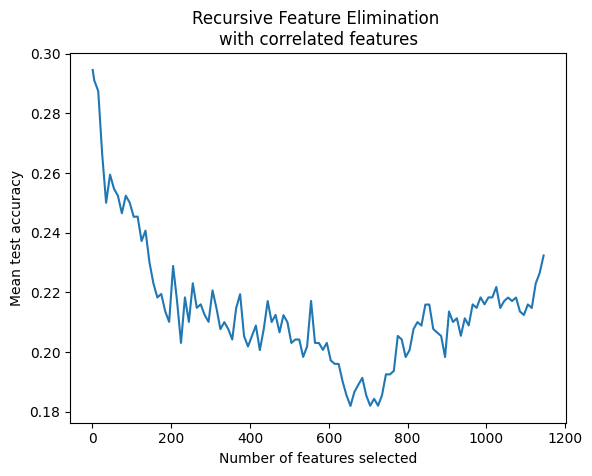

In [22]:
optimizer_results = pd.DataFrame(feature_optimizer.cv_results_)
plt.figure()
plt.xlabel('Number of features selected')
plt.ylabel('Mean test accuracy')
plt.plot(optimizer_results['n_features'], optimizer_results['mean_test_score'])
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

### Let's try a different method to reduce the dimensionality of the problem. We will employ the Joint Mutual Information Maximisation (JMIM) algorithm developed by M. Bennasar, Y. Hicks, and R. Setchi (2015) to extract a subset of maximally-informative features from the full data.

In [23]:
# Define how many features to select using the JMIM algorithm
num_features = 50

# Initialize dictionaries to store the accuracy of the models
accuracy_scores_knn = {n: [] for n in range(1,num_features+1)}
accuracy_scores_logistic = accuracy_scores_knn.copy()
accuracy_scores_ridge = accuracy_scores_knn.copy()

In [24]:
# Apply the JMIM algorithm to find the subset of maximally-informative features with size given
# by num_features
x_train_k = featureSelectionJMIM(x_train, y_train_main.to_frame(), num_features)

# Train and evaluate the model
col_names = x_train_k.columns

### We will then train OneVsRest classifiers with different estimators using the subset of features and plot the different model accuracies as a function of the number of features used.

In [25]:
for k in range(1,num_features+1):
    x_train_k_normed = StandardScaler().fit_transform(x_train_k.iloc[:,range(0,k)])
    accuracy_scores_knn[k] = cross_val_score(OneVsRestClassifier(KNeighborsClassifier(n_neighbors = 50)),
                                         x_train_k_normed, y_train_main_enc, cv = 10)
    accuracy_scores_logistic[k] = cross_val_score(OneVsRestClassifier(LogisticRegression()),
                                                  x_train_k_normed, y_train_main_enc, cv = 10)
    accuracy_scores_ridge[k] = cross_val_score(OneVsRestClassifier(RidgeClassifier()),
                                               x_train_k_normed, y_train_main_enc, cv = 10)

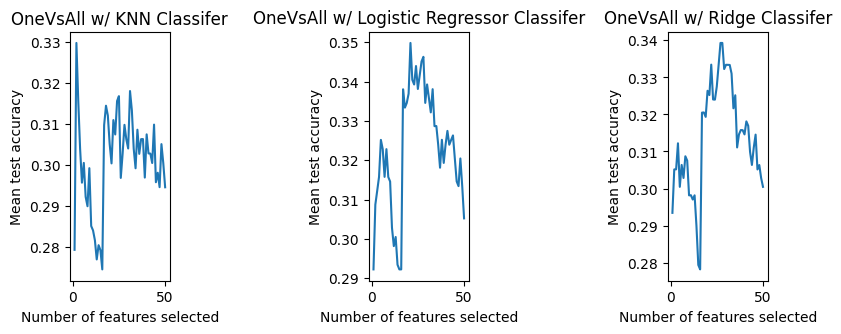

In [26]:
fig = plt.figure(figsize = (9, 4))
grid = fig.add_gridspec(nrows = 1, ncols = 3, wspace = 2)
axs = grid.subplots()
fig.suptitle = 'Feature Selection Using \nJoint Mutual Information Maximization'
axs[0].plot(accuracy_scores_knn.keys(), [np.mean(scores) for scores in accuracy_scores_knn.values()])
axs[0].set_title('OneVsAll w/ KNN Classifer')
axs[0].set_box_aspect(2.5)
axs[1].plot(accuracy_scores_logistic.keys(), [np.mean(scores) for scores in accuracy_scores_logistic.values()])
axs[1].set_title('OneVsAll w/ Logistic Regressor Classifer')
axs[1].set_box_aspect(2.5)
axs[2].plot(accuracy_scores_ridge.keys(), [np.mean(scores) for scores in accuracy_scores_ridge.values()])
axs[2].set_title('OneVsAll w/ Ridge Classifer')
axs[2].set_box_aspect(2.5)
for ax in axs.flat:
    ax.set(xlabel = 'Number of features selected', ylabel = 'Mean test accuracy')

plt.show()

### Based on the two feature selection methods, it seems that the multiclass accuracy of the model is not very high (maximum around 33%) when comparing all disorders against each other as well as against the healthy patients. 

### It's also worthwhile to analyze the distribution of the selected features among different EEG parameters such as PSD vs. COH, between the different frequency bands, between lobes, etc.

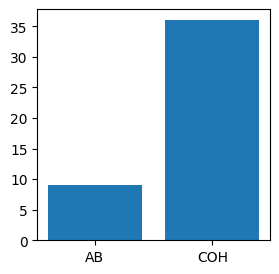

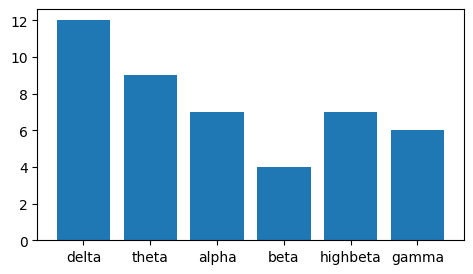

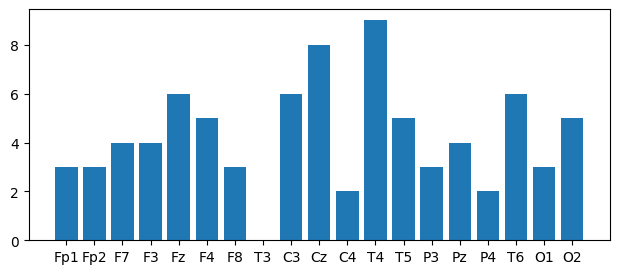

In [27]:
# Plot the distributions of the different EEG parameters among the selected columns
plot_feature_distributions(col_names)

### Now, as in Park et al., (2021), let's divide the dataset into several subsets such that we can build up the comparison from a binary classification to a multiclass classification and see the effects of adding more classes.
### Schizophrenia

Optimal number of features: 1


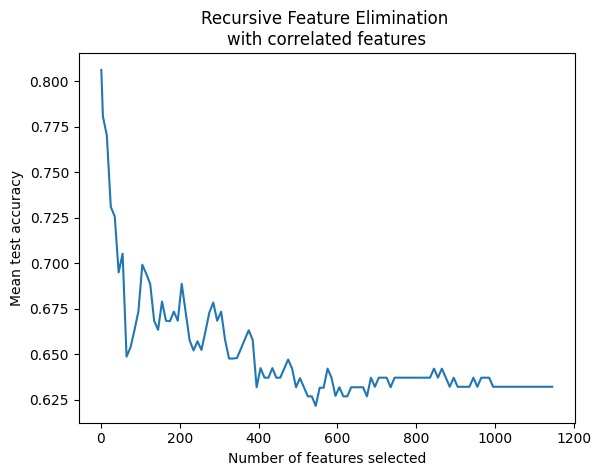

KeyboardInterrupt: 

In [30]:
# Define how many features to select using the JMIM algorithm
num_features = 50

# Compare the JMIM algorithm to the RFE algorithm and plot the average model accuracy as a function of number of features
x_train_sch_optim, y_train_sch_enc, n_feature_optim = fit_disorder(x_train, y_train_main,
                                                                   'Schizophrenia', num_features,
                                                                   plotRFE = True, plotJMIM = True)

### Set up a grid search to vary the hyperparameters of the classifier with the best performing estimator

In [ ]:
# Use a grid search with 10-fold cross-validation to vary the model's hyperparameters and optimize the accuracy
grid_params = {'estimator__penalty':['l1','l2','elasticnet'], 'estimator__C':[0.001,0.01,0.1,1,10,100],
              'estimator__l1_ratio':[0.2,0.4,0.6,0.8]}
x_train_sch_optim_normed = StandardScaler().fit_transform(x_train_sch_optim)
grid_logistic = GridSearchCV(estimator = OneVsRestClassifier(LogisticRegression(solver = 'saga',
                                                                                max_iter = 1000)),
                             param_grid = grid_params,
                             scoring = 'accuracy',
                             cv = 10, error_score = 'raise')
grid_logistic.fit(x_train_sch_optim_normed, y_train_sch_enc)

# Store the number of features and the names of those features in a dictionary
col_names_sch = x_train_sch_optim.columns.to_list()

# Train and evaluate the LogisticRegression model
best_score_sch = grid_logistic.best_score_
best_params_sch = grid_logistic.best_params_

In [ ]:
print('best mean accuracy score using 10-fold cross-validation is {}'.format(best_score_sch))
print('best model hyperparams using 10-fold cross-validation are {}'.format(best_params_sch))
print('maximally-informative features used: {}'.format(col_names_sch))

### Addictive Disorder

In [ ]:
# Define how many features to select using the JMIM algorithm
num_features = 50

# Compare the JMIM algorithm to the RFE algorithm and plot the average model accuracy as a function of number of features
x_train_AD_optim, y_train_AD_enc, n_feature_optim = fit_disorder(x_train, y_train_main,
                                                                 'Addictive disorder', num_features,
                                                                 plotRFE = True, plotJMIM = True)

### Set up a grid search to vary the hyperparameters of the classifier with the best performing estimator

In [ ]:
# Use a grid search with 10-fold cross-validation to vary the model's hyperparameters and optimize the accuracy
grid_params = {'estimator__alpha':[0.001,0.01,0.1,1,10,100]}
x_train_AD_optim_normed = StandardScaler().fit_transform(x_train_AD_optim)
grid_ridge = GridSearchCV(estimator = OneVsRestClassifier(RidgeClassifier()),
                          param_grid = grid_params,
                          scoring = 'accuracy',
                          cv = 10, error_score = 'raise')
grid_ridge.fit(x_train_AD_optim_normed, y_train_AD_enc)

# Store the number of features and the names of those features in a dictionary
col_names_AD = x_train_AD_optim.columns.to_list()

# Train and evaluate the LogisticRegression model
best_score_AD = grid_ridge.best_score_
best_params_AD = grid_ridge.best_params_

In [112]:
print('best mean accuracy score using 10-fold cross-validation is {}'.format(best_score_AD))
print('best model hyperparams using 10-fold cross-validation are {}'.format(best_params_AD))
print('maximally-informative features used: {}'.format(col_names_AD))

best mean accuracy score using 10-fold cross-validation is 0.7523076923076923
best model hyperparams using 10-fold cross-validation are {'estimator__alpha': 100}
maximally-informative features used: ['IQ', 'age', 'COH.C.alpha.h.T3.m.T5', 'COH.B.theta.h.T3.m.T5', 'education', 'COH.E.highbeta.h.T3.k.C4', 'F', 'COH.D.beta.p.P4.r.O1', 'COH.D.beta.j.Cz.s.O2', 'COH.B.theta.c.F7.j.Cz', 'COH.F.gamma.g.F8.n.P3', 'COH.E.highbeta.g.F8.j.Cz', 'COH.A.delta.h.T3.i.C3', 'COH.C.alpha.d.F3.g.F8', 'COH.F.gamma.i.C3.q.T6', 'COH.E.highbeta.o.Pz.s.O2', 'COH.E.highbeta.j.Cz.k.C4', 'COH.E.highbeta.c.F7.l.T4', 'COH.F.gamma.j.Cz.n.P3', 'COH.C.alpha.b.FP2.l.T4', 'COH.A.delta.f.F4.o.Pz', 'COH.D.beta.d.F3.p.P4', 'COH.C.alpha.o.Pz.s.O2', 'COH.B.theta.j.Cz.p.P4', 'COH.C.alpha.k.C4.n.P3', 'AB.A.delta.r.O1', 'COH.F.gamma.e.Fz.m.T5', 'COH.C.alpha.e.Fz.s.O2', 'COH.E.highbeta.c.F7.r.O1', 'AB.C.alpha.n.P3', 'COH.C.alpha.f.F4.k.C4']


### Mood Disorder

In [385]:
# Create a subset of the x_train and y_train data that includes only the rows for which the value in the
# y_train columns is either 'Mood disorder' or 'Healthy control'
bool_rows = [val == 'Mood disorder' or val == 'Healthy control' for val in y_train_main.to_list()]
x_train_MD = x_train_normed.loc[bool_rows, :]
y_train_MD = y_train_main.loc[bool_rows]

In [393]:
feature_optimizer_MD = RFECV(estimator = RidgeClassifier(),
                          step = 10,
                          cv = StratifiedKFold(10),
                          scoring= 'accuracy',
                          min_features_to_select = 1,
                          n_jobs=2).fit(x_train_MD, y_train_MD)

Optimal number of features: 15


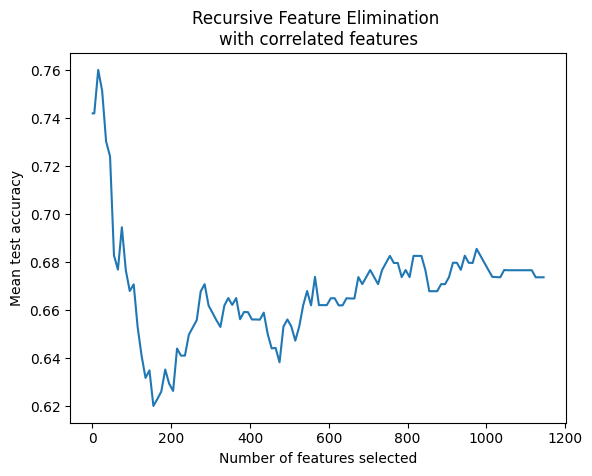

In [394]:
print('Optimal number of features: {}'.format(feature_optimizer_MD.n_features_))
optimizer_results = pd.DataFrame(feature_optimizer_MD.cv_results_)
plt.figure()
plt.xlabel('Number of features selected')
plt.ylabel('Mean test accuracy')
plt.plot(optimizer_results['n_features'], optimizer_results['mean_test_score'])
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

### Train the model on the optimal number of features (k ~ 15)

In [388]:
# Define how many features to select using the JMIM algorithm
num_features = feature_optimizer_MD.n_features_

# Apply the JMIM algorithm to get a subset of maximally-informative features, train a 
# LogisticRegression model, and evaluate the accuracy using 10-fold cross-validation
x_train_MD_k_normed = featureSelectionJMIM(x_train_MD, y_train_MD, num_features)

# Store the number of features and the names of those features in a dictionary
col_names_MD = {num_features: x_train_MD_k.columns}

# Train and evaluate the LogisticRegression model
accuracy_scores_MD = cross_val_score(OneVsRestClassifier(RidgeClassifier()),
                                      x_train_MD_k_normed, y_train_MD, cv = 10)

C:\Users\ricar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\stats\_entropy.py:378: RuntimeWarning: divide by zero encountered in log
  logs = np.log(n * differences / (ci * m))
C:\Users\ricar\AppData\Local\Temp\ipykernel_6320\1122321767.py:57: RuntimeWarning: invalid value encountered in scalar subtract
  jmi_col =  col_ent - sum_MI
C:\Users\ricar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\stats\_entropy.py:378: RuntimeWarning: divide by zero encountered in log
  logs = np.log(n * differences / (ci * m))
C:\Users\ricar\AppData\Local\Temp\ipykernel_6320\1122321767.py:97: RuntimeWarning: invalid value encountered in scalar subtract
  jmi_col =  col_ent - sum_MI
C:\Users\ricar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\stats\_entropy.py:378

In [395]:
print('average accuracy score using 10-fold cross-validation is {}'.format(np.mean(accuracy_scores_MD)))
print('feature columns used: {}'.format(col_names_MD[num_features]))

average accuracy score using 10-fold cross-validation is 0.7688948306595366
feature columns used: Index(['IQ', 'age', 'AB.D.beta.b.FP2', 'COH.C.alpha.k.C4.o.Pz',
       'COH.B.theta.j.Cz.n.P3', 'AB.D.beta.p.P4', 'AB.D.beta.g.F8',
       'AB.A.delta.n.P3', 'COH.B.theta.a.FP1.o.Pz', 'COH.C.alpha.k.C4.n.P3',
       'AB.D.beta.o.Pz', 'COH.B.theta.f.F4.k.C4', 'COH.A.delta.a.FP1.o.Pz',
       'AB.A.delta.r.O1', 'AB.D.beta.a.FP1'],
      dtype='object')


### Obsessive-Compulsive Disorder

In [398]:
# Create a subset of the x_train and y_train data that includes only the rows for which the value in the
# y_train columns is either 'Obsessive compulsive disorder' or 'Healthy control'
bool_rows = [val == 'Obsessive compulsive disorder' or val == 'Healthy control' for val in y_train_main.to_list()]
x_train_OCD = x_train_normed.loc[bool_rows, :]
y_train_OCD = y_train_main.loc[bool_rows]

In [416]:
feature_optimizer_OCD = RFECV(estimator = RidgeClassifier(),
                          step = 10,
                          cv = StratifiedKFold(10),
                          scoring= 'accuracy',
                          min_features_to_select = 1,
                          n_jobs=2).fit(x_train_OCD, y_train_OCD)

Optimal number of features: 1


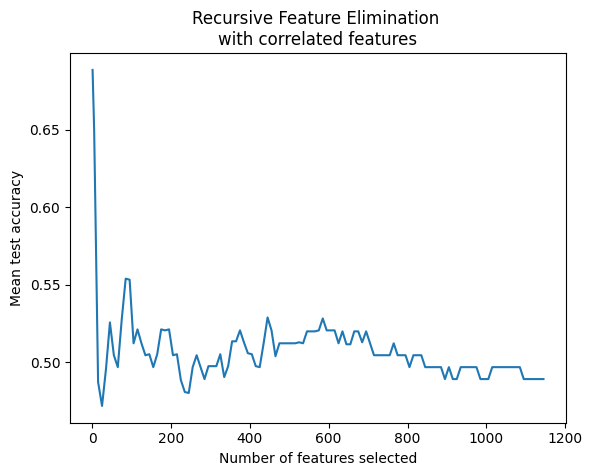

In [417]:
print('Optimal number of features: {}'.format(feature_optimizer_OCD.n_features_))
optimizer_results = pd.DataFrame(feature_optimizer_OCD.cv_results_)
plt.figure()
plt.xlabel('Number of features selected')
plt.ylabel('Mean test accuracy')
plt.plot(optimizer_results['n_features'], optimizer_results['mean_test_score'])
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

### Train the model on the optimal number of features (k ~ )

In [401]:
# Define how many features to select using the JMIM algorithm
num_features = feature_optimizer_OCD.n_features_

# Apply the JMIM algorithm to get a subset of maximally-informative features, train a 
# LogisticRegression model, and evaluate the accuracy using 10-fold cross-validation
x_train_OCD_k_normed = featureSelectionJMIM(x_train_OCD, y_train_OCD, num_features)

# Store the number of features and the names of those features in a dictionary
col_names_OCD = {num_features: x_train_OCD_k.columns}

# Train and evaluate the LogisticRegression model
accuracy_scores_OCD = cross_val_score(OneVsRestClassifier(RidgeClassifier()),
                                      x_train_OCD_k_normed, y_train_OCD, cv = 10)

C:\Users\ricar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\stats\_entropy.py:378: RuntimeWarning: divide by zero encountered in log
  logs = np.log(n * differences / (ci * m))
C:\Users\ricar\AppData\Local\Temp\ipykernel_6320\1122321767.py:57: RuntimeWarning: invalid value encountered in scalar subtract
  jmi_col =  col_ent - sum_MI


In [402]:
print('average accuracy score using 10-fold cross-validation is {}'.format(np.mean(accuracy_scores_OCD)))
print('feature columns used: {}'.format(col_names_OCD[num_features]))

average accuracy score using 10-fold cross-validation is 0.7044871794871795
feature columns used: Index(['age'], dtype='object')


### Anxiety Disorder

In [403]:
# Create a subset of the x_train and y_train data that includes only the rows for which the value in the
# y_train columns is either 'Anxiety disorder' or 'Healthy control'
bool_rows = [val == 'Anxiety disorder' or val == 'Healthy control' for val in y_train_main.to_list()]
x_train_anx = x_train_normed.loc[bool_rows, :]
y_train_anx = y_train_main.loc[bool_rows]

In [404]:
feature_optimizer_anx = RFECV(estimator = RidgeClassifier(),
                          step = 10,
                          cv = StratifiedKFold(10),
                          scoring= 'accuracy',
                          min_features_to_select = 1,
                          n_jobs=2).fit(x_train_anx, y_train_anx)

Optimal number of features: 5


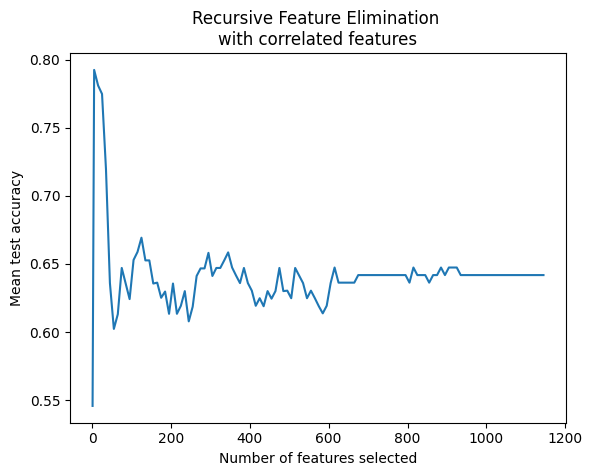

In [405]:
print('Optimal number of features: {}'.format(feature_optimizer_anx.n_features_))
optimizer_results = pd.DataFrame(feature_optimizer_anx.cv_results_)
plt.figure()
plt.xlabel('Number of features selected')
plt.ylabel('Mean test accuracy')
plt.plot(optimizer_results['n_features'], optimizer_results['mean_test_score'])
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

### Train the model on the optimal number of features (k ~ )

In [406]:
# Define how many features to select using the JMIM algorithm
num_features = feature_optimizer_anx.n_features_

# Apply the JMIM algorithm to get a subset of maximally-informative features, train a 
# LogisticRegression model, and evaluate the accuracy using 10-fold cross-validation
x_train_anx_k_normed = featureSelectionJMIM(x_train_anx, y_train_anx, num_features)

# Store the number of features and the names of those features in a dictionary
col_names_anx = {num_features: x_train_anx_k.columns}

# Train and evaluate the LogisticRegression model
accuracy_scores_anx = cross_val_score(OneVsRestClassifier(RidgeClassifier()),
                                      x_train_anx_k_normed, y_train_anx, cv = 10)

C:\Users\ricar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\stats\_entropy.py:378: RuntimeWarning: divide by zero encountered in log
  logs = np.log(n * differences / (ci * m))
C:\Users\ricar\AppData\Local\Temp\ipykernel_6320\1122321767.py:57: RuntimeWarning: invalid value encountered in scalar subtract
  jmi_col =  col_ent - sum_MI
C:\Users\ricar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\stats\_entropy.py:378: RuntimeWarning: divide by zero encountered in log
  logs = np.log(n * differences / (ci * m))
C:\Users\ricar\AppData\Local\Temp\ipykernel_6320\1122321767.py:97: RuntimeWarning: invalid value encountered in scalar subtract
  jmi_col =  col_ent - sum_MI
C:\Users\ricar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\stats\_entropy.py:378

In [407]:
print('average accuracy score using 10-fold cross-validation is {}'.format(np.mean(accuracy_scores_anx)))
print('feature columns used: {}'.format(col_names_anx[num_features]))

average accuracy score using 10-fold cross-validation is 0.757843137254902
feature columns used: Index(['IQ', 'age', 'COH.A.delta.h.T3.j.Cz', 'COH.A.delta.a.FP1.k.C4',
       'AB.F.gamma.s.O2'],
      dtype='object')


### Trauma- and Stress-Related Disorder

In [408]:
# Create a subset of the x_train and y_train data that includes only the rows for which the value in the
# y_train columns is either 'Trauma and stress related disorder' or 'Healthy control'
bool_rows = [val == 'Trauma and stress related disorder' or val == 'Healthy control' for val in y_train_main.to_list()]
x_train_TSRD = x_train_normed.loc[bool_rows, :]
y_train_TSRD = y_train_main.loc[bool_rows]

In [409]:
feature_optimizer_TSRD = RFECV(estimator = RidgeClassifier(),
                          step = 10,
                          cv = StratifiedKFold(10),
                          scoring= 'accuracy',
                          min_features_to_select = 1,
                          n_jobs=2).fit(x_train_TSRD, y_train_TSRD)

Optimal number of features: 5


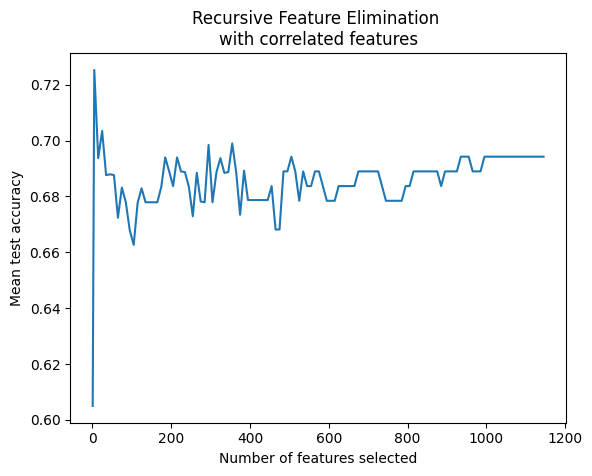

In [410]:
print('Optimal number of features: {}'.format(feature_optimizer_TSRD.n_features_))
optimizer_results = pd.DataFrame(feature_optimizer_TSRD.cv_results_)
plt.figure()
plt.xlabel('Number of features selected')
plt.ylabel('Mean test accuracy')
plt.plot(optimizer_results['n_features'], optimizer_results['mean_test_score'])
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

### Train the model on the optimal number of features (k ~ )

In [411]:
# Define how many features to select using the JMIM algorithm
num_features = feature_optimizer_TSRD.n_features_

# Apply the JMIM algorithm to get a subset of maximally-informative features, train a 
# LogisticRegression model, and evaluate the accuracy using 10-fold cross-validation
x_train_TSRD_k_normed = featureSelectionJMIM(x_train_TSRD, y_train_TSRD, num_features)

# Store the number of features and the names of those features in a dictionary
col_names_TSRD = {num_features: x_train_TSRD_k.columns}

# Train and evaluate the LogisticRegression model
accuracy_scores_TSRD = cross_val_score(OneVsRestClassifier(RidgeClassifier()),
                                      x_train_TSRD_k_normed, y_train_TSRD, cv = 10)

C:\Users\ricar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\stats\_entropy.py:378: RuntimeWarning: divide by zero encountered in log
  logs = np.log(n * differences / (ci * m))
C:\Users\ricar\AppData\Local\Temp\ipykernel_6320\1122321767.py:57: RuntimeWarning: invalid value encountered in scalar subtract
  jmi_col =  col_ent - sum_MI
C:\Users\ricar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\stats\_entropy.py:378: RuntimeWarning: divide by zero encountered in log
  logs = np.log(n * differences / (ci * m))
C:\Users\ricar\AppData\Local\Temp\ipykernel_6320\1122321767.py:97: RuntimeWarning: invalid value encountered in scalar subtract
  jmi_col =  col_ent - sum_MI
C:\Users\ricar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\stats\_entropy.py:378

In [412]:
print('average accuracy score using 10-fold cross-validation is {}'.format(np.mean(accuracy_scores_TSRD)))
print('feature columns used: {}'.format(col_names_TSRD[num_features]))

average accuracy score using 10-fold cross-validation is 0.7823684210526316
feature columns used: Index(['age', 'IQ', 'AB.D.beta.f.F4', 'AB.D.beta.k.C4', 'AB.D.beta.a.FP1'], dtype='object')


### Compile all the features that were selected by each of the binary classification steps and use only those features to train a final multiclass prediction model

In [445]:
col_names_JMIM = set([*col_names_sch.values()][0].to_list()) | set([*col_names_AD.values()][0].to_list()) |\
                 set([*col_names_MD.values()][0].to_list()) | set([*col_names_OCD.values()][0].to_list()) |\
                 set([*col_names_anx.values()][0].to_list()) | set([*col_names_TSRD.values()][0].to_list())
x_train_JMIM_normed = x_train_normed[list(col_names_JMIM)]

In [447]:
model_JMIM = OneVsRestClassifier(LogisticRegression()).fit(x_train_JMIM_normed, y_train_main)

In [448]:
accuracy_scores_JMIM = cross_val_score(OneVsRestClassifier(LogisticRegression()),
                                       x_train_JMIM_normed, y_train_main, cv = 10)
print('average accuracy score using 10-fold cross-validation is {}'.format(np.mean(accuracy_scores_JMIM)))
print('feature columns used: {}'.format(col_names_JMIM))

average accuracy score using 10-fold cross-validation is 0.2851983584131327
feature columns used: {'COH.A.delta.h.T3.j.Cz', 'COH.A.delta.a.FP1.o.Pz', 'COH.C.alpha.n.P3.o.Pz', 'COH.A.delta.a.FP1.k.C4', 'AB.D.beta.m.T5', 'COH.E.highbeta.i.C3.n.P3', 'AB.D.beta.f.F4', 'COH.A.delta.j.Cz.n.P3', 'AB.C.alpha.n.P3', 'AB.D.beta.o.Pz', 'AB.D.beta.h.T3', 'AB.D.beta.j.Cz', 'COH.B.theta.a.FP1.o.Pz', 'COH.A.delta.d.F3.h.T3', 'AB.F.gamma.h.T3', 'AB.D.beta.b.FP2', 'AB.D.beta.n.P3', 'COH.B.theta.i.C3.j.Cz', 'COH.B.theta.f.F4.k.C4', 'COH.B.theta.r.O1.s.O2', 'AB.A.delta.m.T5', 'COH.C.alpha.c.F7.m.T5', 'COH.B.theta.j.Cz.n.P3', 'COH.C.alpha.k.C4.n.P3', 'COH.C.alpha.k.C4.o.Pz', 'COH.B.theta.f.F4.o.Pz', 'AB.A.delta.r.O1', 'AB.D.beta.g.F8', 'age', 'COH.B.theta.n.P3.o.Pz', 'COH.D.beta.j.Cz.n.P3', 'AB.D.beta.a.FP1', 'IQ', 'COH.E.highbeta.m.T5.n.P3', 'COH.B.theta.j.Cz.o.Pz', 'AB.F.gamma.j.Cz', 'AB.F.gamma.s.O2', 'AB.A.delta.n.P3', 'COH.D.beta.j.Cz.o.Pz', 'AB.D.beta.k.C4', 'COH.B.theta.i.C3.o.Pz', 'COH.A.delta.n.P